In [92]:
import os

import numpy as np
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.metrics as skm

from sklearn.manifold import TSNE

!pip install umap-learn
import umap.umap_ as umap

In [93]:
# GOOGLE COLAB
USE_GOOGLE_COLAB = True # Are you using Google Colab ?
COLAB_WORKING_PATH = "/content/drive/My Drive/Colab/Botanist" # Path to folder in Google Drive

# Mount on Google Drive
if USE_GOOGLE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)

# PATHS
DATASET_ZIP_PATH = f"{COLAB_WORKING_PATH}/herbier.zip" # Path to zipped data
DATASET_PATH = "/content/data/" # Where the unzipped data should land ?

WORD_DATA_PATH = f"{DATASET_PATH}/herbier/data_public/words/"
METADATA_PATH = f"{DATASET_PATH}/herbier/data_public/ascii/words.txt"

# CNN
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 75

CLASSES = ['a01-000u', 'c03-000a', 'b05-032']
N_CLASSES = len(CLASSES)

FLATTEN_LAYER_NAME = 'flattened'

DEBUG = True

Mounted at /content/drive/


In [94]:
#!mkdir $DATASET_PATH
#!unzip "$DATASET_ZIP_PATH" -d $DATASET_PATH

mkdir: cannot create directory ‘/content/data/’: File exists
Archive:  /content/drive/My Drive/Colab/Botanist/herbier.zip
replace /content/data/herbier/articles/1-s2.0-S0957417421008848-main.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## TODO
- cross-validation
-
- voir pour ignorer le fichier METADATA
- prétraitement image
  - réduire spectre pixels

Loaded 210 words.
  Writer ID: a01-000u; image shape: (51, 27, 1)
  Writer ID: a01-000u; image shape: (48, 213, 1)
  Writer ID: a01-000u; image shape: (50, 70, 1)
  Writer ID: a01-000u; image shape: (78, 166, 1)
  Writer ID: a01-000u; image shape: (61, 126, 1)
number of writers:  3


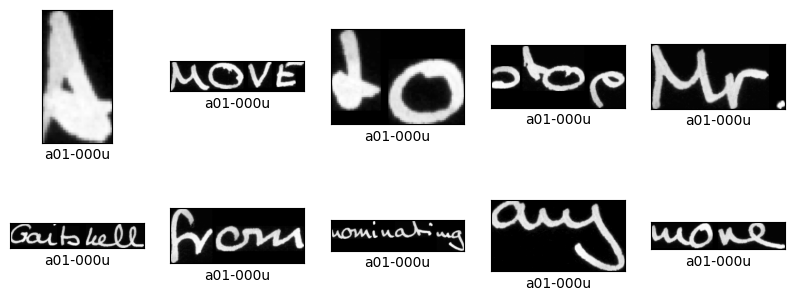

In [95]:
def load_words_data(data_path, metadata_path, selected_writers = []):
    if selected_writers == []:
        raise ValueError("selected_writers must be a non-empty list of writer IDs")

    data = []

    with open(METADATA_PATH, 'r') as file:
        for line in file:
            if not line.startswith("#"):
                components = line.strip().split(' ')
                word_id = components[0]

                parts = word_id.split('-')
                writer_id = '-'.join(parts[:2])

                if writer_id in selected_writers:
                    image_subfolder = parts[0]
                    image_filename = f"{word_id}.png"
                    image_path = os.path.join(data_path, image_subfolder, writer_id, image_filename)

                    if os.path.exists(image_path):
                        try:
                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img)
                            data.append({
                                'image_path': image_path,
                                'writer_id': writer_id,
                                'image_array': img
                            })
                        except tf.errors.InvalidArgumentError:
                            print(f"Image not found for word ID: {word_id} at {image_path}")
                    else:
                        print(f"Image not found for word ID: {word_id} at {image_path}")

    return data

words_data = load_words_data(WORD_DATA_PATH, METADATA_PATH, selected_writers=CLASSES)
images = [entry['image_array'] for entry in words_data]
labels = [entry['writer_id'] for entry in words_data]

def plot_images(images, labels, num=10):
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

if DEBUG:
  print(f"Loaded {len(words_data)} words.")
  for entry in words_data[:5]:
      print(f"  Writer ID: {entry['writer_id']}; image shape: {entry['image_array'].shape}")

  print("number of writers: ", len(set([entry['writer_id'] for entry in words_data])))

  plot_images(images, labels)


X_train: (118, 50, 75, 1); y_train: (118,)
X_test: (30, 50, 75, 1); y_test: (30,)


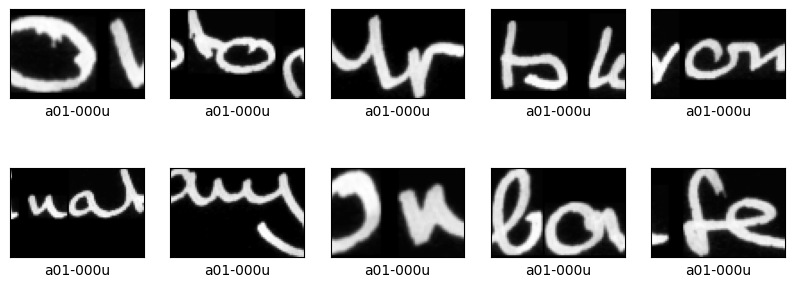

In [96]:
def preprocess_data(data):
    labels = []
    images = []

    for entry in data:
        # Resize the image while preserving aspect ratio
        img = np.array(entry['image_array'])
        old_size = img.shape[:2]

        ratio = float(IMAGE_HEIGHT)/old_size[0]
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        # Ignore images that are too narrows
        if new_size[1] < IMAGE_WIDTH:
          continue;

        # Crop images that are too wide
        if new_size[1] > IMAGE_WIDTH:
            start_x = (new_size[1] - IMAGE_WIDTH) // 2
            img = img[:, start_x:start_x + IMAGE_WIDTH]
            new_size = (new_size[0], IMAGE_WIDTH)

        img = img.astype('float32') / 255.0

        # Ensure dimensions format is correct: (sample_n, width, height, channels)
        img = np.expand_dims(img, axis=-1)
        delta_w = IMAGE_WIDTH - new_size[1]
        delta_h = IMAGE_HEIGHT - img.shape[0]
        delta_w = IMAGE_WIDTH - img.shape[1]
        padding = ((0, delta_h), (0, delta_w), (0, 0))
        img = np.pad(img, padding, 'constant')

        images.append(img)
        labels.append(entry['writer_id'])

    return np.array(images), np.array(labels)


images, labels = preprocess_data(words_data)
X_train, X_test, y_train, y_test = skms.train_test_split(images, labels, test_size=0.2, random_state=42)

if DEBUG:
  print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
  print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")
  plot_images(images, labels)

In [97]:
# encode labels
label_encoder = skp.LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)
one_hot_encoded_labels = keras.utils.to_categorical(integer_encoded_labels)

X_train, X_test, y_train, y_test = skms.train_test_split(images, one_hot_encoded_labels, test_size=0.2, random_state=42)

integer_class_labels = np.argmax(y_train, axis=1)

if DEBUG:
    print(f"X_train: {X_train.shape}; y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}; y_test: {y_test.shape}")
    # number of training samples per class
    print("number of training samples per class: ", np.bincount(integer_class_labels))


X_train: (118, 50, 75, 1); y_train: (118, 3)
X_test: (30, 50, 75, 1); y_test: (30, 3)
number of training samples per class:  [29 59 30]


In [98]:
# data augmentation
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

In [99]:
input_layer = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))

# Define L1 and L2 regularization
l1_l2 = keras.regularizers.l1_l2(l1=0, l2=1e-4)

# path 1
conv1_1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
pool1_1 = keras.layers.MaxPooling2D((2, 2))(conv1_1)
conv1_2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool1_1)
pool1_2 = keras.layers.MaxPooling2D((2, 2))(conv1_2)

# path 2
conv2_1 = keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(input_layer)
pool2_1 = keras.layers.MaxPooling2D((2, 2))(conv2_1)
conv2_2 = keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same', kernel_regularizer=l1_l2)(pool2_1)
pool2_2 = keras.layers.MaxPooling2D((2, 2))(conv2_2)

# merge paths
merged = keras.layers.concatenate([pool1_2, pool2_2])

flat = keras.layers.Flatten()(merged)
dense1 = keras.layers.Dense(128, activation='relu', kernel_regularizer=l1_l2, name=FLATTEN_LAYER_NAME)(flat)
dropout = keras.layers.Dropout(0.2)(dense1)  # Consider experimenting with the dropout rate
output_layer = keras.layers.Dense(N_CLASSES, activation='softmax')(dropout)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)


if DEBUG:
    model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 50, 75, 1)]          0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 50, 75, 32)           320       ['input_8[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 50, 75, 32)           832       ['input_8[0][0]']             
                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 25, 37, 32)           0         ['conv2d_28[0][0]']           
 ng2D)                                                                                      

In [100]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
BATCH_SIZE = 5
EPOCHS = 30

train_generator = data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)

class_weights = sku.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(integer_class_labels),
    y=integer_class_labels
)
class_weights_dict = {i : weight for i, weight in enumerate(class_weights)}

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,  # Number of batches per epoch
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/30
23/23 [==============================] - 9s 317ms/step - loss: 1.2211 - accuracy: 0.3717 - val_loss: 1.0287 - val_accuracy: 0.4333
Epoch 2/30
23/23 [==============================] - 7s 318ms/step - loss: 0.9453 - accuracy: 0.6195 - val_loss: 0.8900 - val_accuracy: 0.6333
Epoch 3/30
23/23 [==============================] - 6s 244ms/step - loss: 0.7740 - accuracy: 0.7345 - val_loss: 0.5181 - val_accuracy: 0.7667
Epoch 4/30
23/23 [==============================] - 3s 146ms/step - loss: 0.5369 - accuracy: 0.7434 - val_loss: 0.4486 - val_accuracy: 0.8000
Epoch 5/30
23/23 [==============================] - 3s 144ms/step - loss: 0.4557 - accuracy: 0.8142 - val_loss: 0.4649 - val_accuracy: 0.8000
Epoch 6/30
23/23 [==============================] - 5s 203ms/step - loss: 0.3818 - accuracy: 0.8142 - val_loss: 0.3847 - val_accuracy: 0.8000
Epoch 7/30
23/23 [==============================] - 4s 153ms/step - loss: 0.3678 - accuracy: 0.8696 - val_loss: 0.2326 - val_accuracy: 0.9333
Epoch 

In [102]:
feature_layer = model.get_layer(FLATTEN_LAYER_NAME).output

# Create a feature extractor model
feature_extractor_model = keras.models.Model(inputs=model.input, outputs=feature_layer)

# Now you can use this model to extract features
features = feature_extractor_model.predict(X_train)

4/4 [==============================] - 1s 115ms/step


features shape: (118, 128)


<ipython-input-103-3665c322ce1f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-103-3665c322ce1f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-103-3665c322ce1f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', N_CLASSES))
<ipython-input-103-3665c322ce1f>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated

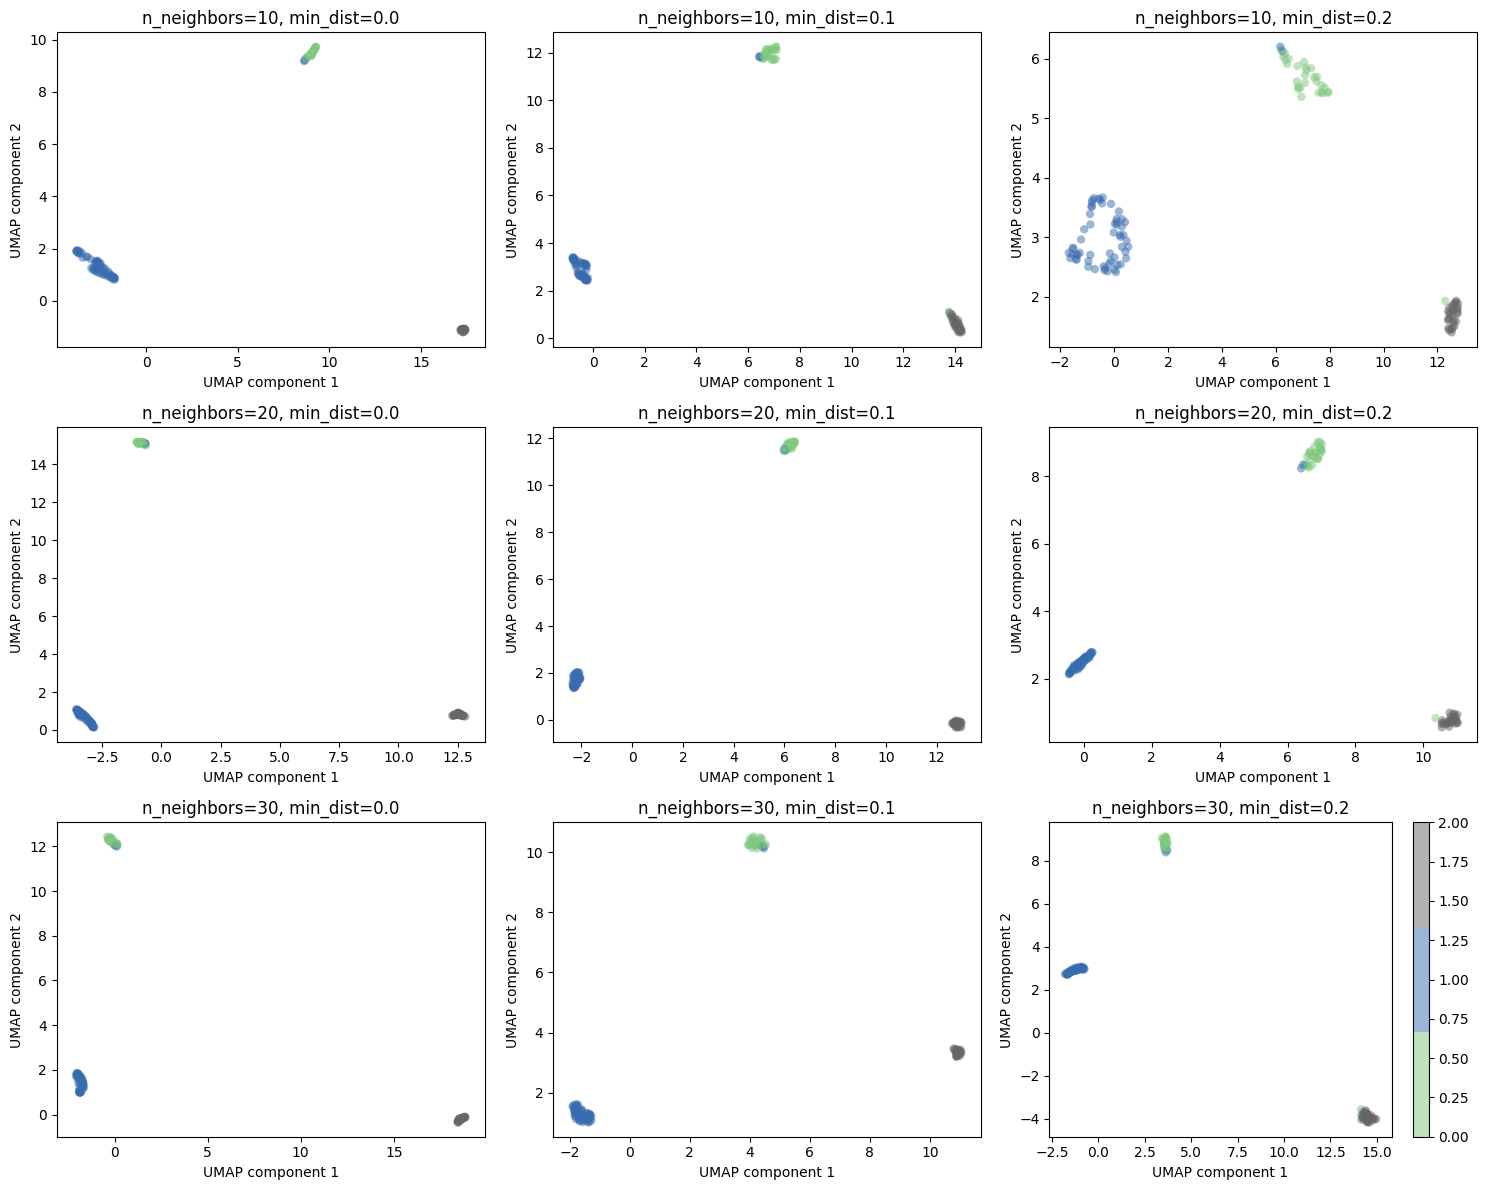

In [103]:
# features = model.predict(X_train)

if DEBUG:
    print(f"features shape: {features.shape}")

# Standardize the features
scaler = skp.StandardScaler()
features_standardized = scaler.fit_transform(features)

# Now, use the standardized features with UMAP
def evaluate_model(n_neighbors, min_dist, ax):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=32, metric='euclidean')
    embedding = reducer.fit_transform(np.nan_to_num(features_standardized))

    sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                    c=integer_class_labels, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Accent', N_CLASSES))
    ax.set_xlabel('UMAP component 1')
    ax.set_ylabel('UMAP component 2')
    ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

    if n_neighbors == n_neighbors_list[-1] and min_dist == min_dist_list[-1]:
        plt.colorbar(sc, ax=ax)

n_neighbors_list = [10, 20, 30]
min_dist_list = [0.0, 0.1, 0.2]

fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(15, 12))

axes = axes.flatten()

for idx, (n_neighbors, min_dist) in enumerate([(x, y) for x in n_neighbors_list for y in min_dist_list]):
    evaluate_model(n_neighbors, min_dist, axes[idx])

plt.tight_layout()
plt.show()